# Γιάννης Δαλιάνης 1115201700027

Τα text πεδία έχουν γραφεί με βάση το colab markdown

# Ερώτημα 1

## Ζητούμενο 1

In [1]:
%matplotlib inline
%pylab inline

import os
import numpy as np
import numpy.linalg as LA
from google.colab import drive
from PIL import Image
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn import metrics, svm
from sklearn.svm import SVR
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

!pip install python-resize-image
from resizeimage import resizeimage

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Οι εικόνες γίνονται imported από το google drive

In [2]:
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'DI/images/'

Mounted at /content/gdrive


In [3]:
def loadImages(path):

  arr = list()
  labels = list()

  for filename in os.listdir(path):

    if filename[0]=="W":
      labels.append(0)
    elif filename[0]=="F":
      labels.append(1)
    else:
      labels.append(2)

    with open(path + '/' + filename, 'r+b') as f:
      with Image.open(f) as image:

        cover = resizeimage.resize_cover(image, [100, 100])
        cover.save(path + '/' + filename, image.format)

        # convert image to numpy array
        data = np.asarray(cover)

        actual = data.reshape(30000, 1)

        arr.append(actual)

  return np.array(arr).T, labels

Πίνακας Δεδομένων και labels. Τα labels είναι 0 για χειμώνα, 1 για φθινόπωρο και 2 για άνοιξη

In [4]:
imAr, labels = loadImages(base_dir)

imAr = imAr.reshape(30000, 30)
print("Image labels are:", labels)

print("type(imAr)", type(imAr))
print("imAr.shape", imAr.shape)

print(imAr[:5])

Image labels are: [2, 1, 2, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 0, 2, 1, 0, 1, 1, 1]
type(imAr) <class 'numpy.ndarray'>
imAr.shape (30000, 30)
[[  0 132  57  68 174  50  80 139  58  49 134   2  27 171 156  66 188  76
  245  56 152  18 137  46   0 145  67  85  58  61]
 [  1  44  63  68 140  66  81 143  78  51 141   3  16 232 153  50 202  39
  241  65 152   2 138  59   0 110  61  65  26  88]
 [  0   0  35  78 157  82  83 144 115  64 149   7  32 255 146  34 211  20
  230  60 164  12  78  78   9  88  63   2  11 105]
 [  2 195  64  76 151  94  76 166  83  83 116   2  28 183 184  65 200  61
  239  58 121  20  96  59   9 134  86  99  64  69]
 [  4 115  70  76 121 110  79 170 105  87 123   3  15 233 181  50 215  25
  235  68 121   2  99  72  12 100  80  79  33  95]]


Έλεγχος ότι οι διαστάσεις όλων των εικόνων έχουν αλλάξει σε 100 επί 100 pixels

In [5]:
for filename in os.listdir(base_dir):
  image = Image.open(base_dir + '/' + filename)
  print(filename,"has size", image.size)  # size in pixels as a 2-tuple (width, height)

S3.jpg has size (100, 100)
F9.jpg has size (100, 100)
S9.jpg has size (100, 100)
W9.jpg has size (100, 100)
F10.jpg has size (100, 100)
W4.jpg has size (100, 100)
S10.jpg has size (100, 100)
W2.jpg has size (100, 100)
F8.jpg has size (100, 100)
F4.jpg has size (100, 100)
W6.jpg has size (100, 100)
S7.jpg has size (100, 100)
F3.jpg has size (100, 100)
S4.jpg has size (100, 100)
W3.jpg has size (100, 100)
S2.jpg has size (100, 100)
W5.jpg has size (100, 100)
F7.jpg has size (100, 100)
W7.jpg has size (100, 100)
S8.jpg has size (100, 100)
W1.jpg has size (100, 100)
S5.jpg has size (100, 100)
S6.jpg has size (100, 100)
W8.jpg has size (100, 100)
S1.jpg has size (100, 100)
F5.jpg has size (100, 100)
W10.jpg has size (100, 100)
F1.jpg has size (100, 100)
F2.jpg has size (100, 100)
F6.jpg has size (100, 100)


## Ζητούμενο 2

In [6]:
def plotImage(x, y, ax, rIm):
  bb = Bbox.from_bounds(x,y,30,30)  
  bb2 = TransformedBbox(bb,ax.transData)
  bbox_image = BboxImage(bb2,
                      norm = None,
                      origin=None,
                      clip_on=False)

  bbox_image.set_data(rIm)
  ax.add_artist(bbox_image)


def PCADF(df, comps):  # takes a dataframe and return another with the pca values
  scaled_features = StandardScaler().fit_transform(df.values)
  df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

  # make list of col names
  nAms = list()
  for i in range(comps):
    nAms.append("PC"+str(i+1))

  pca = PCA(n_components=comps)
  principalComponents = pca.fit_transform(df.values)
  principalDf = pd.DataFrame(data = principalComponents, columns = nAms)
  
  return principalDf


def PCA_ImageSpaceVisualization(X): # X is the data array

  df = pd.DataFrame(data=X)         # convert to dataframe
  df = df.T

  principalDf = PCADF(df, 2)

  fig = plt.figure(figsize = (15,15))
  ax = fig.add_subplot(111)
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA', fontsize = 20)

  for x, y, im in zip(principalDf["PC1"], principalDf["PC2"], X.T):
    img = Image.fromarray(im.reshape((100, 100, 3)), 'RGB')
    plotImage(x, y, ax, img)

  ax.set_ylim(-200,200)
  ax.set_xlim(-200,250)
  ax.grid()

  return

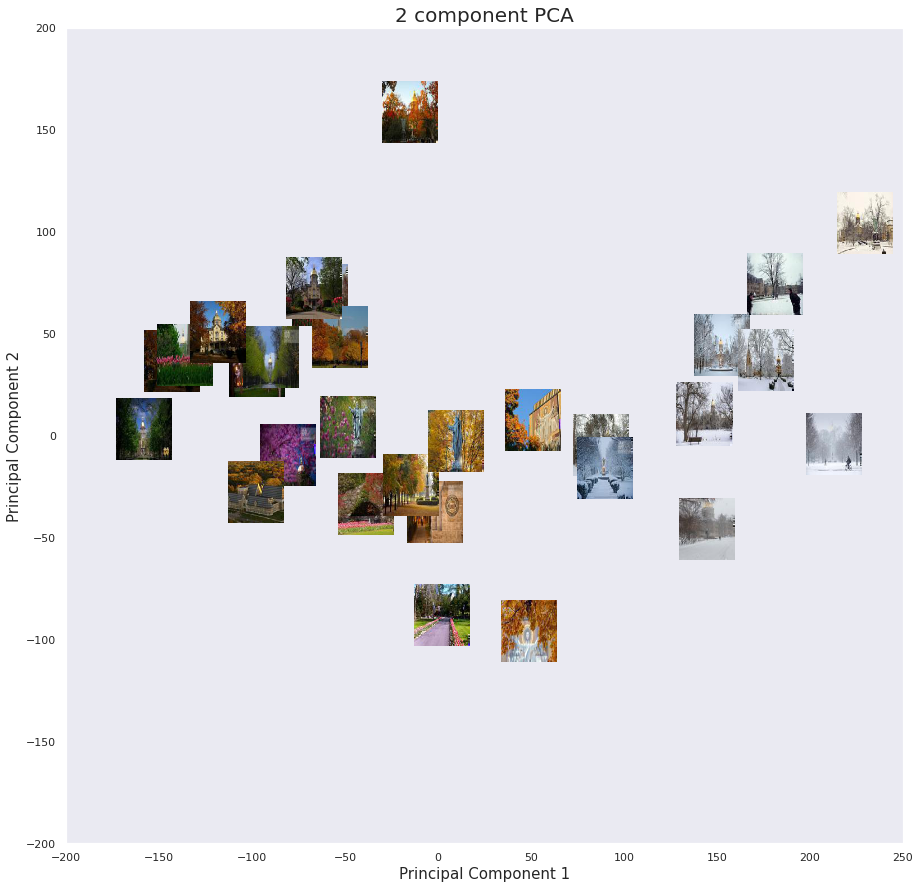

In [7]:
PCA_ImageSpaceVisualization(imAr)

##### 2.1

Η PCA είναι μια dimensionality-reduction μέθοδος που χρησιμοποιεί μόνο τα σημαντικότερα χαρακτηριστικά από τα δεδομένα για να τα συγκρίνει πιο εύκολα και γρήγορα και για να είναι ευκολότερη η οπτικοποίησή τους. Όσο πιο κοντά βρίσκονται δύο εικόνες μεταξύ τους στο plot, τόσο πιο πανομοιότυπες είναι με βάση τις δύο πρώτες κύριες συνιστώσες, ενώ όσο πιο μακριά βρίσκονται τόσο λιγότερο πανομοιότυπες είναι.
Τα συμπεράσματα αυτά γενικεύονται και για τον μεγάλης διάστασης αρχικό χώρο χαρακτηριστικών των εικόνων. Εφαρμόζοντας PCA δεν αλλοιώνονται τα χαρακτηριστικά των δεδομένων, αλλά μόνο απλοποιούνται. Αν κάναμε μια αντίστοιχη σύγκριση χρησιμοποιώντας όλα τα αρχικά features θα είχαμε ίδια και ίσως σαφέστερα αποτελέσματα όσον αφορά τις εικόνες, μόνο που θα απαιτούνταν εκτενέστερη και πιο αργή επεξεργασία.

##### 2.2
Οι χειμωνιάτικες εικόνες ομαδοποιούνται πιο κοντά μεταξύ τους και είναι ευδιάκριτος ο διαχωρισμός τους από τις εικόνες των άλλων δύο εποχών οι οποίες σε κάποιο βαθμό είναι ανακατεμένες. Η ξεκάθαρη αυτή ομαδοποίηση των χειμωνιάτικων εικόνων συμβαίνει λόγω των χρωματικών τους αποχρώσεων που τις κάνουν να ξεχωρίζουν αρκετά απο τις ανοιξιάτικες και τις φθινοπωρινές. Έχουν πιο γκρι, λευκά και μουντά χρώματα που τις διαφοροποιούν από τις άλλες δύο κατηγορίες.

## Ζητούμενο 3

In [8]:
def splitData(data, labels, t_size):
  # Split dataset into training set and test set
  return train_test_split(data, labels, test_size=t_size, random_state=109)

def crossValS(data, labels, best_svr):
  print("5-fold cross validation")

  scores = []
  labelAr = numpy.array(labels)
  cv = KFold(n_splits=5, shuffle=False)
  for train_index, test_index in cv.split(data):

      X_train, X_test, y_train, y_test = data[train_index], data[test_index], labelAr[train_index], labelAr[test_index]
      best_svr.fit(X_train, y_train)
      scores.append(best_svr.score(X_test, y_test))

  print("Mean Score:", np.mean(scores))
  print("cross_val_score", cross_val_score(best_svr, data, labels, cv=5))

def K1NN(data, labels, X_train, X_test, y_train, y_test):

  knn = KNeighborsClassifier(n_neighbors=1, weights='distance')

  #Train the model using the training sets
  knn.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = knn.predict(X_test)

  # Model Accuracy, how often is the classifier correct?
  print("Classification Accuracy:",metrics.accuracy_score(y_test, y_pred))

  crossValS(data, labels, knn)

  return


def SVMclas(data, labels, X_train, X_test, y_train, y_test):

  clf = svm.SVC(kernel='linear', C=1.0) # Linear Kernel

  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

  crossValS(data, labels, clf)
  return

def PCADFWithComp(df):  # takes a dataframe and return another with the pca values
  scaled_features = StandardScaler().fit_transform(df.values)
  df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

  n_components = 30 ## how may componets to compute
  pca = PCA(n_components=n_components, whiten=True).fit(df.values)
  components = pca.transform(df.values)
  
  cumExplainedVar=np.cumsum(pca.explained_variance_ratio_)

  plt.figure(figsize=(10, 10))
  numOfComp=10
  plt.subplot(2, 2, 1)
  plt.bar(range(numOfComp),pca.explained_variance_ratio_[:numOfComp])
  plt.xlabel(' components ')
  plt.ylabel(' explained variance');

  plt.subplot(2, 2, 2)
  plt.plot(cumExplainedVar[:10])
  plt.xlabel('number of components retained (10 first)')
  plt.ylabel('cumulative explained variance');

  plt.subplot(2, 2, 3)
  plt.plot(cumExplainedVar[:20])
  plt.xlabel('number of components retained (20 first)')
  plt.ylabel('cumulative explained variance');

  plt.subplot(2, 2, 4)
  plt.plot(cumExplainedVar)
  plt.xlabel('number of components retained (30)')
  plt.ylabel('cumulative explained variance');

  plt.show()

  return

Classification Accuracy:

$Accuracy=\frac{TP+TN}{TP+FP+TN+FN}$

where:<br>
TP = True Positive<br>
TN = True Negative<br>
FP = False Positive<br>
FP = False Negative<br>

Σε κάθε ένα από τα παρακάτω fields εκτελούνται οι μέθοδοι για τους διάφορους τύπους δεδομένων(1-ΝΝ και SVM για τις αρχικές
μεγάλης διάστασης εικόνες σε μορφή διανύσματος και για τα χαρακτηριστικά χαμηλής διάστασης που εξάγονται μέσω της PCA). Υπολογίζεται το Classification Accuracy(3.1) και πραγματοποιείται 5-fold cross validation(3.2)

(3.3)<br>
Για την ορθή χρήση της PCA είναι πολύ σημαντική η ικανότητα εκτίμησης της διάστασης των χαρακτηριστικών που εξάγουμε. Αυτό μπορεί να προσδιοριστεί εξετάζοντας το σωρευτικό λόγο της εξηγούμενης διακύμανσης σε σχέση με τον αριθμό των κυρίων συνιστωσών

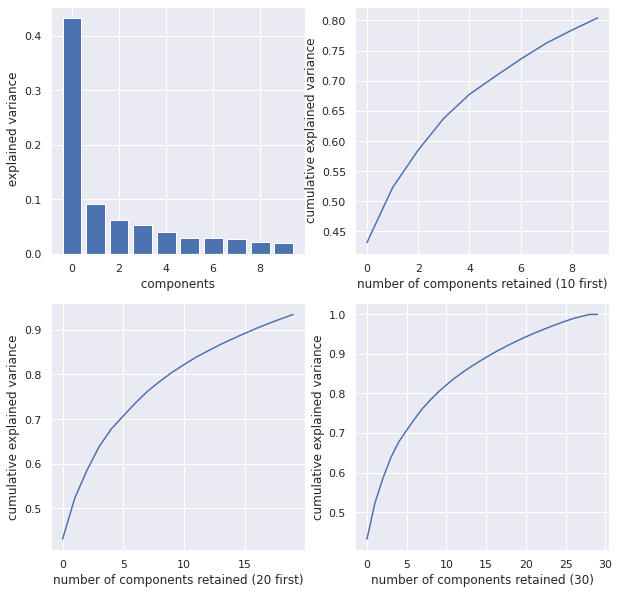

In [9]:
df = pd.DataFrame(data=imAr)
df = df.T

PCADFWithComp(df)

Παρατηρούμε ότι οι δύο πρώτες συνιστώσες εξηγούν περίπου το 58% της διακύμανσης των δεδομένων μας ενώ για το 90% χρειάζονται περίπου 16 συνιστώσες. Παρακάτω αναλύουμε τα δεδομένα στις 10 πρώτες συνιστώσες, ένας αριθμός που είναι αρκετά μεγάλος για να έχουμε καλή περιγραφή των δεδομένων και αρκετά μικρός για να μην είναι πολύ χρονοβόροι οι υπολογισμοί.

1-ΝΝ σε μεγάλης διάστασης εικόνες σε μορφή διανύσματος.

In [10]:
tmp = imAr.T

X_train, X_test, y_train, y_test = splitData(tmp, labels, 0.3)

K1NN(tmp, labels, X_train, X_test, y_train, y_test)

Classification Accuracy: 0.6666666666666666
5-fold cross validation
Mean Score: 0.7333333333333334
cross_val_score [0.83333333 0.5        0.66666667 0.83333333 1.        ]


1-ΝΝ σε χαρακτηριστικά χαμηλής διάστασης μέσω της PCA

In [11]:
principalDf = PCADF(df, 10)

X_train, X_test, y_train, y_test = splitData(principalDf.to_numpy(), labels, 0.3)

K1NN(principalDf.to_numpy(), labels, X_train, X_test, y_train, y_test)

Classification Accuracy: 0.6666666666666666
5-fold cross validation
Mean Score: 0.6333333333333333
cross_val_score [0.83333333 0.5        0.66666667 0.83333333 0.66666667]


SVM σε μεγάλης διάστασης εικόνες σε μορφή διανύσματος.

In [12]:
X_train, X_test, y_train, y_test = splitData(tmp, labels, 0.3)

SVMclas(tmp, labels, X_train, X_test, y_train, y_test)

Accuracy: 0.7777777777777778
5-fold cross validation
Mean Score: 0.7333333333333334
cross_val_score [0.83333333 0.66666667 0.5        0.83333333 1.        ]


SVM σε χαρακτηριστικά χαμηλής διάστασης μέσω της PCA

In [13]:
X_train, X_test, y_train, y_test = splitData(principalDf.to_numpy(), labels, 0.3)

SVMclas(principalDf.to_numpy(), labels, X_train, X_test, y_train, y_test)

Accuracy: 0.7777777777777778
5-fold cross validation
Mean Score: 0.7666666666666667
cross_val_score [0.83333333 0.5        0.83333333 0.83333333 0.66666667]


Καλύτερη επίδοση έχει ο ταξινομητής SVM όπως βλέπουμε από τα mean scores του cross validation και από τα classification accuracy scores. Αυτό ήταν αναμενόμενο, εφόσον ο SVM υπολογίζει τις ακραίες τιμές(outliers) καλύτερα από ότι ο KNN, ενώ ο KNN είναι καλύτερος από τον SVM μόνο στην περίπτωση που το πλήθος των δεδομένων εκπαίδευσης είναι κατά πολύ μεγαλύτερο από το πλήθος των χαρακτηριστικών.
<br>Πηγή:
<br>https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222#:~:text=SVM%20take%20cares%20of%20outliers,features%20and%20lesser%20training%20data.

# Ερώτημα 2

Μελετούμε το πρόβλημα βελτιστοποίησης 
<br><br>
$$\min_{W, C}∥X − WC∥^2_F + λ∥W∥^2_F + λ∥C∥^2_F s.t.W ≥ 0, C ≥ 0$$

Μελετήθηκαν δύο τρόποι για την επίλυση του προβλήματος.
<br>
###Πρώτος τρόπος, ο οποίος είναι και ο κατά πολύ πιο αποδοτικός:
<br>Δεδομένου ότι για το πρόβλημα ελαχίστων τετραγώνων που συζητήθηκε στο μάθημα<br><br>
$$\min_{W,C} l(W,C) = ∥ X − WC ∥ _F^2 s.t.W ≥ 0, C ≥ 0 $$

καταλήγουμε στους εξής τύπους ενημέρωσης των παραμέτρων:<br><br>
$ C_{[t+1]} = C_{[t]} − n_t*∇_{C_{[t]}} l (W,C_{[t]}) $  
<br>
$ W_{[t+1]} = W_{[t]} − n_t*∇_{W_{[t]}} l (W_{[t]},C) $  
<br>
t = t + 1
<br>
ή ισοδύναμα<br>
$C_{[t+1]} =C_{[t]}*\frac{W_{[t]}^TX}{W_{[t]}^TW_{[t]}C_{[t]}} $  
<br>
$W_{[t+1]} =W_{[t]}*\frac{XC_{[t]}^T}{W_{[t]}C_{[t]}C_{[t]}^T} $
<br>t = t + 1  

τότε, αντίστοιχα για το ζητούμενο πρόβλημα καταλήγουμε στους εξής τύπους με βάση την πηγή https://stats.stackexchange.com/questions/351359/deriving-multiplicative-update-rules-for-nmf:<br><br>
$ C_{[t+1]} = C_{[t]} * \frac{W^TX} {W^TWC_{[t]} + λC_{[t]}} $  
<br>
$ W_{[t+1]} = W_{[t]} * \frac{XC^T} {W_{[t]}CC^T + λW_{[t]}} $
<br>
t = t + 1  
<br>
## Aιτιολόγηση:  

$$\min_{W,C} l(W,C) = ∥ X − WC ∥ _F^2 s.t.W ≥ 0, C ≥ 0 $$
από $ ∥ X ∥ _F^2 = Tr(X^TX) $ παίρνουμε ισοδύναμα<br><br>
$Tr((X-WC)^T(X-WC)) + λTr(W^TW) + λTr(C^TC) =$<br>  
$Tr(X^TX - X^TWC -C^TW^TX + C^TW^TWC) + λTr(W^TW) + λTr(C^TC)=$<br>
$Tr(X^T) - Tr(X^TWC) - Tr(C^TW^TX) + Tr(C^TW^TWC) + λTr(W^TW) + λTr(C^TC)$

<br>Με παραγώγιση ως προς W έχουμε:<br><br>
$ ∇_W Tr(X^T) - ∇_W Tr(X^TWC) - ∇_W Tr(C^TW^TX) + ∇_W Tr(C^TW^TWC) + ∇_W
λTr(W^TW) + ∇_W λTr(C^TC)$<br><br>

Με βάση τις ιδιότητες:<br>
$ ∇_X Tr(AX) = A^T $<br>
$ ∇_X Tr(X^TA) = A $<br>
$ ∇_X Tr(XAA^TX^T) = X(A + A^T)$<br><br>

Yπολογίζουμε τις παραγώγους:<br>
$ ∇_W Tr(X^TX) = 0$<br><br>
$ ∇_W Tr(X^TWC) = ∇_W Tr(CX^TW) = (CX^T)^T = XC^T$<br><br>
$ ∇_W Tr(C^TW^TX) = ∇_W Tr(XC^TW^T) = XC^T $<br><br>
$ ∇_W Tr(C^TW^TWC) = ∇_W Tr(WCC^TW^T) = W(CC^T + (CC^T)^T) = 2WCC^T$<br><br>
$ ∇_W λTr(W^TW) = ∇_W λTr(WIW^T) = λW(I + I^T) = 2λW$<br><br>
$ ∇_W λTr(C^TC) = 0 $<br><br>


Έτσι καταλήγουμε ότι<br><br>
$ ∇_W f(W,C) = 2WCC^T + 2λW - 2XC^T$<br><br>
Έπομένως<br><br>
$ W_{[t+1]} = W_{[t]} - n_t*∇_{W_{[t]}} l (W_{[t]},C)=$<br><br>
$W_{[t]} - n_t * (2W_{[t]}CC^T + 2λW_{[t]} - 2XC^T)$<br><br>
Η σταθερά 2 μπορεί να προσαρμοστεί στο learning rate $(n_t)$ και έτσι μπορεί να αγνοηθεί σε αυτό το σημείο:<br><br>
$ W_{[t+1]} = W_{[t]} - n_t * (W_{[t+1]}CC^T - XC^T + λW_{[t+1]})$<br>
ή ισοδύναμα<br><br>
$ W_{[t+1]} = W_{[t]} * \frac{XC^T} {W_{[t]}CC^T + λW_{[t]}}$<br><br>

Αντίστοιχα με παραγώγιση ως προς C καταλήγουμε ότι<br>
$ C_{[t+1]} = C_{[t]} * \frac{W^TX} {W^TWC_{[t]} + λC_{[t]}} $

Για να διαπιστώσουμε εάν συγκλίνει στη βέλτιστη λύση ο επαναληπτικός αλγόριθμος παρακολουθούμε το σφάλμα ανακατασκευής
<br><br>$\frac{∥X − W_{[t]}C_{[t]}∥^2_F}{∥X∥^2_F}$ <br><br>

σε κάθε επανάληψη και εάν η μεταβολή του ανάμεσα σε δύο διαδοχικές επαναλήψεις είναι μικρότερη από ένα κατώφλι $ε$
<br><br>$\frac{∥X − W_{[t]}C_{[t]}∥^2_F - ∥X − W_{[t-1]}C_{[t-1]}∥^2_F}{∥X∥^2_F} < ε$ <br><br>
με $ε$ = 0.01 ή 0.001 ή 0.0001 τερματίζουμε τον αλγόριθμο. Το $t$ στις παραπάνω σχέσεις συμβολίζει το δείκτη επανάληψης.

In [14]:
# W : matrix of basis vectors
# C : matrix of coefficients
# frob_error : frobenius norm
def frobenius_norm(X,W,C):
		#error between X and W*H
		error = LA.norm(X - np.dot(W, C))
		return error

def C_update(X, W, C, l):
  numerator = np.dot(W.T, X)
  denominator = np.dot(W.T, W.dot(C)) + l*C
  C = np.multiply(C, numerator) / denominator
  return C

def W_update(X, W, C, l):
  numerator = X.dot(C.T)
  denominator = W.dot(C.dot(C.T)) + l*W
  W = np.multiply(W, numerator) / denominator
  return W

def RegUNMF(X, k, lambdaL, epsilon):
  X_dim, samples = X.shape
  W = np.random.random((X_dim, k))
  C = np.random.random((k, samples))

  diff = epsilon + 1
  iters=0
  while diff>=epsilon:
    iters+=1
    wNew=W_update(X, W, C, lambdaL)
    cNew=C_update(X, W, C, lambdaL)

    diff = abs(frobenius_norm(X, wNew, cNew) - frobenius_norm(X, W, C)) / LA.norm(X)

    W = wNew
    C = cNew

  return (wNew, cNew, iters)

def RunReg(X, rank, l, epsilon):
  W, C, iters = RegUNMF(X, rank, l, epsilon)

  print(75*"-")
  print("For rank=", rank, "and l=", l, "and epsilon=", epsilon, iters, "iterations made")
  print (34*"-", "X", 34*"-")
  print (X)
  # print (34*"-", "W", 34*"-")
  # print (W)
  # print (34*"-", "C", 34*"-")
  # print (H)
  print (27*"-", "W.dot(C)", 27*"-")
  print (W.dot(C))
  print (25*"-", "(X - np.dot(W,C))", 25*"-")
  print(np.ndarray.sum(abs(X - np.dot(W,C)))/500000)
  print(75*"-")

X = np.random.random((500,1000))

$λ=1.0$, $λ=0.1$, $λ=0.01$ για $ε=0.001$

In [15]:
RunReg(X, 1, 1.0, 0.001)
RunReg(X, 10, 1.0, 0.001)
RunReg(X, 100, 1.0, 0.001)

RunReg(X, 1, 0.1, 0.001)
RunReg(X, 10, 0.1, 0.001)
RunReg(X, 100, 0.1, 0.001)

RunReg(X, 1, 0.01, 0.001)
RunReg(X, 10, 0.01, 0.001)
RunReg(X, 100, 0.01, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 1.0 and epsilon= 0.001 2 iterations made
---------------------------------- X ----------------------------------
[[0.84807373 0.291988   0.94104619 ... 0.27291572 0.02144324 0.69294392]
 [0.85217806 0.1110223  0.04774883 ... 0.65896813 0.10323989 0.18166938]
 [0.72737175 0.91722611 0.9275236  ... 0.38899888 0.09456695 0.56684489]
 ...
 [0.22117551 0.93462406 0.70476997 ... 0.23992461 0.07210619 0.78674361]
 [0.35534044 0.04360233 0.90675871 ... 0.43645689 0.55632462 0.1886731 ]
 [0.5715067  0.13110943 0.24379022 ... 0.14774356 0.56178067 0.56547008]]
--------------------------- W.dot(C) ---------------------------
[[0.44107214 0.45105724 0.4550024  ... 0.44646339 0.42387842 0.44847747]
 [0.45589942 0.46622019 0.47029797 ... 0.4614719  0.43812771 0.46355369]
 [0.46996654 0.48060577 0.48480937 ... 0.47571097 0.45164647 0.47785699]
 ...
 [0.45532393 0.46563167 0.46970431 ... 0.46088939 0.4375746

Παρατηρούμε ότι το βέλτιστο αποτέλεσμα το έχουμε για $k$= 100 και $λ$= 0.01. Ωστόσο η συγκεκριμένη εκτέλεση απαιτεί αισθητά περισσότερο χρόνο και εκτελεί πολλές περισσότερες επαναλήψεις(15656) έναντι του αμέσως χειρότερου αποτελέσματος($k$= 100, $λ$= 0.1 με 1628 επαναλήψεις)

$λ=1.0$, $λ=0.1$ για $ε=0.01$

In [16]:
RunReg(X, 1, 1.0, 0.01)
RunReg(X, 10, 1.0, 0.01)
RunReg(X, 100, 1.0, 0.01)

RunReg(X, 1, 0.1, 0.01)
RunReg(X, 10, 0.1, 0.01)
RunReg(X, 100, 0.1, 0.01)

---------------------------------------------------------------------------
For rank= 1 and l= 1.0 and epsilon= 0.01 2 iterations made
---------------------------------- X ----------------------------------
[[0.84807373 0.291988   0.94104619 ... 0.27291572 0.02144324 0.69294392]
 [0.85217806 0.1110223  0.04774883 ... 0.65896813 0.10323989 0.18166938]
 [0.72737175 0.91722611 0.9275236  ... 0.38899888 0.09456695 0.56684489]
 ...
 [0.22117551 0.93462406 0.70476997 ... 0.23992461 0.07210619 0.78674361]
 [0.35534044 0.04360233 0.90675871 ... 0.43645689 0.55632462 0.1886731 ]
 [0.5715067  0.13110943 0.24379022 ... 0.14774356 0.56178067 0.56547008]]
--------------------------- W.dot(C) ---------------------------
[[0.43095802 0.44094057 0.44420668 ... 0.43622148 0.41379957 0.43805772]
 [0.44575309 0.45607835 0.45945658 ... 0.45119725 0.42800558 0.45309653]
 [0.45970125 0.4703496  0.47383355 ... 0.46531577 0.4413984  0.46727448]
 ...
 [0.44531346 0.45562853 0.45900344 ... 0.45075224 0.42758345

Παρατηρούμε ότι το βέλτιστο αποτέλεσμα το έχουμε για $k$= 100 και $λ$= 0.1. Ωστόσο η συγκεκριμένη εκτέλεση απαιτεί περισσότερο χρόνο και εκτελεί περισσότερες επαναλήψεις(1280) έναντι του αμέσως χειρότερου αποτελέσματος($k$= 100, $λ$= 1.0 με 184 επαναλήψεις)

$λ=2.0$, $λ=5.0$ για $ε=0.001$

In [17]:
RunReg(X, 1, 2.0, 0.001)
RunReg(X, 10, 2.0, 0.001)
RunReg(X, 100, 2.0, 0.001)

RunReg(X, 1, 5.0, 0.001)
RunReg(X, 10, 5.0, 0.001)
RunReg(X, 100, 5.0, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 2.0 and epsilon= 0.001 3 iterations made
---------------------------------- X ----------------------------------
[[0.84807373 0.291988   0.94104619 ... 0.27291572 0.02144324 0.69294392]
 [0.85217806 0.1110223  0.04774883 ... 0.65896813 0.10323989 0.18166938]
 [0.72737175 0.91722611 0.9275236  ... 0.38899888 0.09456695 0.56684489]
 ...
 [0.22117551 0.93462406 0.70476997 ... 0.23992461 0.07210619 0.78674361]
 [0.35534044 0.04360233 0.90675871 ... 0.43645689 0.55632462 0.1886731 ]
 [0.5715067  0.13110943 0.24379022 ... 0.14774356 0.56178067 0.56547008]]
--------------------------- W.dot(C) ---------------------------
[[0.54956751 0.56199543 0.5664722  ... 0.55615625 0.52780818 0.55856024]
 [0.56844228 0.58129704 0.58592756 ... 0.57525731 0.54593563 0.57774386]
 [0.58588747 0.59913673 0.60390936 ... 0.59291165 0.5626901  0.5954745 ]
 ...
 [0.56756037 0.58039519 0.58501852 ... 0.57436483 0.5450886

Παρατηρούμε ότι το βέλτιστο αποτέλεσμα το έχουμε για $k$= 100 και $λ$= 2.0 με 128 επαναλήψεις

$λ=2.0$, $λ=5.0$ για $ε=0.01$

In [18]:
RunReg(X, 1, 2.0, 0.01)
RunReg(X, 10, 2.0, 0.01)
RunReg(X, 100, 2.0, 0.01)

RunReg(X, 1, 5.0, 0.01)
RunReg(X, 10, 5.0, 0.01)
RunReg(X, 100, 5.0, 0.01)

---------------------------------------------------------------------------
For rank= 1 and l= 2.0 and epsilon= 0.01 2 iterations made
---------------------------------- X ----------------------------------
[[0.84807373 0.291988   0.94104619 ... 0.27291572 0.02144324 0.69294392]
 [0.85217806 0.1110223  0.04774883 ... 0.65896813 0.10323989 0.18166938]
 [0.72737175 0.91722611 0.9275236  ... 0.38899888 0.09456695 0.56684489]
 ...
 [0.22117551 0.93462406 0.70476997 ... 0.23992461 0.07210619 0.78674361]
 [0.35534044 0.04360233 0.90675871 ... 0.43645689 0.55632462 0.1886731 ]
 [0.5715067  0.13110943 0.24379022 ... 0.14774356 0.56178067 0.56547008]]
--------------------------- W.dot(C) ---------------------------
[[0.4377442  0.44767483 0.4513977  ... 0.44311457 0.42046995 0.44479857]
 [0.45320644 0.46348784 0.46734222 ... 0.4587665  0.43532202 0.46050999]
 [0.46721182 0.47781094 0.48178443 ... 0.4729437  0.44877471 0.47474106]
 ...
 [0.45260731 0.46287512 0.4667244  ... 0.45816002 0.43474653

Παρατηρούμε ότι το βέλτιστο αποτέλεσμα το έχουμε για $k$= 100 και $λ$= 2.0 με 120 επαναλήψεις

$λ=2.0$, $λ=5.0$ για $ε=0.1$

In [19]:
RunReg(X, 1, 2.0, 0.1)
RunReg(X, 10, 2.0, 0.1)
RunReg(X, 100, 2.0, 0.1)

RunReg(X, 1, 5.0, 0.1)
RunReg(X, 10, 5.0, 0.1)
RunReg(X, 100, 5.0, 0.1)

---------------------------------------------------------------------------
For rank= 1 and l= 2.0 and epsilon= 0.1 2 iterations made
---------------------------------- X ----------------------------------
[[0.84807373 0.291988   0.94104619 ... 0.27291572 0.02144324 0.69294392]
 [0.85217806 0.1110223  0.04774883 ... 0.65896813 0.10323989 0.18166938]
 [0.72737175 0.91722611 0.9275236  ... 0.38899888 0.09456695 0.56684489]
 ...
 [0.22117551 0.93462406 0.70476997 ... 0.23992461 0.07210619 0.78674361]
 [0.35534044 0.04360233 0.90675871 ... 0.43645689 0.55632462 0.1886731 ]
 [0.5715067  0.13110943 0.24379022 ... 0.14774356 0.56178067 0.56547008]]
--------------------------- W.dot(C) ---------------------------
[[0.45165938 0.46189937 0.4655958  ... 0.45703022 0.43378972 0.45916607]
 [0.4672319  0.47782496 0.48164883 ... 0.47278792 0.44874612 0.47499742]
 [0.48120543 0.4921153  0.49605353 ... 0.48692762 0.4621668  0.48920319]
 ...
 [0.46635951 0.47693278 0.48074952 ... 0.47190515 0.44790824 

Παρατηρούμε ότι το βέλτιστο αποτέλεσμα το έχουμε για $k$= 1 και $λ$= 2.0 με 2 επαναλήψεις. Ωστόσο για τις συγκεκριμένες παραμέτρους τα αποτελέσματα είναι χειρότερα σε σχέση με πριν.

$λ=10.0$, $λ=15.0$ για $ε=0.001$

In [20]:
RunReg(X, 1, 10.0, 0.001)
RunReg(X, 10, 10.0, 0.001)
RunReg(X, 100, 10.0, 0.001)

RunReg(X, 1, 15.0, 0.001)
RunReg(X, 10, 15.0, 0.001)
RunReg(X, 100, 15.0, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 10.0 and epsilon= 0.001 32 iterations made
---------------------------------- X ----------------------------------
[[0.84807373 0.291988   0.94104619 ... 0.27291572 0.02144324 0.69294392]
 [0.85217806 0.1110223  0.04774883 ... 0.65896813 0.10323989 0.18166938]
 [0.72737175 0.91722611 0.9275236  ... 0.38899888 0.09456695 0.56684489]
 ...
 [0.22117551 0.93462406 0.70476997 ... 0.23992461 0.07210619 0.78674361]
 [0.35534044 0.04360233 0.90675871 ... 0.43645689 0.55632462 0.1886731 ]
 [0.5715067  0.13110943 0.24379022 ... 0.14774356 0.56178067 0.56547008]]
--------------------------- W.dot(C) ---------------------------
[[0.46697202 0.47753017 0.48134496 ... 0.47257994 0.44848182 0.47460953]
 [0.48302486 0.49394596 0.49789188 ... 0.48882555 0.46389903 0.49092492]
 [0.49782517 0.50908091 0.51314774 ... 0.50380361 0.47811331 0.5059673 ]
 ...
 [0.48225908 0.49316286 0.49710253 ... 0.48805057 0.46316

Παρατηρούμε ότι το βέλτιστο αποτέλεσμα το έχουμε για $k$= 10 και $λ$= 10.0 με 76 επαναλήψεις

$λ=30.0$, $λ=60.0$ για $ε=0.001$

In [21]:
RunReg(X, 1, 30.0, 0.001)
RunReg(X, 10, 30.0, 0.001)
RunReg(X, 100, 30.0, 0.001)

RunReg(X, 1, 60.0, 0.001)
RunReg(X, 10, 60.0, 0.001)
RunReg(X, 100, 60.0, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 30.0 and epsilon= 0.001 13 iterations made
---------------------------------- X ----------------------------------
[[0.84807373 0.291988   0.94104619 ... 0.27291572 0.02144324 0.69294392]
 [0.85217806 0.1110223  0.04774883 ... 0.65896813 0.10323989 0.18166938]
 [0.72737175 0.91722611 0.9275236  ... 0.38899888 0.09456695 0.56684489]
 ...
 [0.22117551 0.93462406 0.70476997 ... 0.23992461 0.07210619 0.78674361]
 [0.35534044 0.04360233 0.90675871 ... 0.43645689 0.55632462 0.1886731 ]
 [0.5715067  0.13110943 0.24379022 ... 0.14774356 0.56178067 0.56547008]]
--------------------------- W.dot(C) ---------------------------
[[0.44331566 0.45333894 0.45696047 ... 0.44863948 0.42576216 0.45056626]
 [0.45855528 0.46892313 0.47266915 ... 0.46406211 0.44039835 0.46605513]
 [0.47260582 0.48329135 0.48715216 ... 0.47828139 0.45389254 0.48033547]
 ...
 [0.45782829 0.4681797  0.47191979 ... 0.46332639 0.43970

Παρατηρούμε ότι το βέλτιστο αποτέλεσμα το έχουμε για $k$= 10 και $λ$= 30.0 με 30 επαναλήψεις

$λ=100.0$ για $ε=0.001$

In [22]:
RunReg(X, 1, 100.0, 0.001)
RunReg(X, 10, 100.0, 0.001)
RunReg(X, 100, 100.0, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 100.0 and epsilon= 0.001 8 iterations made
---------------------------------- X ----------------------------------
[[0.84807373 0.291988   0.94104619 ... 0.27291572 0.02144324 0.69294392]
 [0.85217806 0.1110223  0.04774883 ... 0.65896813 0.10323989 0.18166938]
 [0.72737175 0.91722611 0.9275236  ... 0.38899888 0.09456695 0.56684489]
 ...
 [0.22117551 0.93462406 0.70476997 ... 0.23992461 0.07210619 0.78674361]
 [0.35534044 0.04360233 0.90675871 ... 0.43645689 0.55632462 0.1886731 ]
 [0.5715067  0.13110943 0.24379022 ... 0.14774356 0.56178067 0.56547008]]
--------------------------- W.dot(C) ---------------------------
[[0.3488278  0.35671473 0.35956437 ... 0.3530169  0.33501563 0.35453301]
 [0.36081926 0.36897731 0.37192491 ... 0.36515237 0.34653227 0.36672059]
 [0.37187508 0.3802831  0.38332102 ... 0.37634096 0.35715033 0.37795724]
 ...
 [0.36024722 0.36839234 0.37133527 ... 0.36457346 0.34598

Παρατηρούμε ότι το βέλτιστο αποτέλεσμα το έχουμε για $k$= 1 και $λ$= 100.0 με 8 επαναλήψεις

Από όλες τις εκτελέσεις το καλύτερο αποτέλεσμα το είχαμε για $k=100$, $λ=0.01$ και $ε=0.001$, ωστόσο σε αυτή την περίπτωση πραγματοποιήθηκαν οι πιο πολλές επαναλήψεις(15656). Το αμέσως χειρότερο αποτέλεσμα το πήραμε για $k=100$, $λ=0.1$ και $ε=0.001$ με 1628 επαναλήψεις. Για $λ<=2.0$ τα αποτελέσματα είναι τα πιο ικανοποιητικά, ωστόσο ο αριθμός επαναλήψεων και συνεπώς ο χρόνος εκτέλεσης είναι αισθητά πιο πολύς. Για παράδειγμα, μια εκτέλεση που παράγει αρκετά ικανοποιητικά αποτελέσματα και δε κάνει τόσο μεγάλο αριθμό επαναλήψεων είναι για $k=10$, $λ=10.0$ και $ε=0.001$ με 76 επαναλήψεις.

<br>Στην πλειοψηφία των περιπτώσεων, όσο αυξάνεται το $λ$, αυξάνεται και ο αριθμός των επαναλήψεων που πραγματοποιούνται, αλλά τόσο πιο ακριβή είναι τα αποτελέσματα που λαμβάνουμε. Συμπεραίνουμε πως η επιλογή του $λ$ εξαρτάται και από το πόσο καλά αποτελέσματα θέλουμε να πετύχουμε αλλά και από το πόσο χρόνο είμαστε διατεθειμένοι να δώσουμε στην εκτέλεση. Η επιλογή ενός $λ\in[3.0, 4.0]$ φαίνεται ότι είναι αρκετά ικανοποιητική έχοντας υπόψη τόσο τα αποτελέσματα όσο και το χρόνο εκτέλεσης.

<br>Όσο αυξάνεται το $k$ κρατώντας σταθερές τις υπόλοιπες παραμέτρους αυξάνεται ο αριθμός των επαναλήψεων. Το ίδιο γίνεται και όσο μειώνεται το $ε$ κρατώντας σταθερές τις υπόλοιπες παραμέτρους

##Δεύτερος τρόπος ο οποίος όμως παράγει ικανοποιητικά αποτελέσματα για συγκεκριμένες μόνο παραμέτρους και η χρησιμοποίησή του δε προτείνεται:
<br>με βάση την παρουσίαση https://angms.science/doc/NMF/nmf_2.pdf ως εξής:

Οι W και C αρχικοποιούνται με μη αρνητικές τιμές και σε κάθε βήμα υπολογίζονται οι τιμές 
<br><br>$C_{[t+1]} =C_{[t]}*\frac{W_{[t]}X - λ\nabla{C_{[t]}}}{W_{[t]}^TW_{[t]}C_{[t]}}=C_{[t]}*\frac{W_{[t]}X - λ(W_{[t]}^TW_{[t]}C_{[t]}-W_{[t]}^TΧ)}{W_{[t]}^TW_{[t]}C_{[t]}} $ 

<br>και<br>
$W_{[t+1]} =W_{[t]}*\frac{XC_{[t]}^T - λ\nabla{W_{[t]}}}{W_{[t]}C_{[t]}C_{[t]}^T} = W_{[t]}*\frac{XC_{[t]}^T - λ(C_{[t]}^TC_{[t]}W_{[t]}-C_{[t]}^TΧ)}{W_{[t]}C_{[t]}C_{[t]}^T} $ <br><br>

όπου τo * συμβολίζει το γινόμενο Hadamard (δηλ. γινόμενο στοιχείο προς στοιχείο του πίνακα)<br>
Επιλέγεται ένας αριθμός μέγιστων επαναλήψεων υπολογισμού των πινάκων W και C, έστω 1000

In [23]:
def update_C(X, W, C, l):
  numerator = np.dot(W.T, X) - l*( ((W.T).dot(W)).dot(C) - (W.T).dot(X) )
  denominator = np.dot(W.T.dot(W), C )
  C *= numerator
  C /= denominator
  return C

def update_W(X, W, C, l):
  numerator = X.dot(C.T) - l*( W.dot(np.dot(C, C.T)) - (X).dot(C.T))  
  denominator = W.dot(C.dot(C.T)) 
  W *= numerator
  W /= denominator
  return W

def RegNMF(X, k, lambdaL, epsilon, reps):
  X_dim, samples = X.shape
  W = np.random.random((X_dim, k))
  C = np.random.random((k, samples))

  mis = 0

  while mis<reps:

    wNew=update_W(X, W, C, lambdaL)
    cNew=update_C(X, W, C, lambdaL)

    W = wNew
    C = cNew

    mis+=1

  return (wNew, cNew)

def runReg(X, rank, l, epsilon, reps):
  W, C = RegNMF(X, rank, l, epsilon, reps)
  print(75*"-")
  print("For rank=", rank, "l=", l, "and epsilon=", epsilon)
  print (34*"-", "X", 34*"-")
  print (X)

  # print (34*"-", "W", 34*"-")
  # print (W)
  # print (34*"-", "C", 34*"-")
  # print (C)
  
  print (27*"-", "W.dot(C)", 27*"-")
  print (W.dot(C))
  print (25*"-", "(X - np.dot(W,C))", 25*"-")
  print(np.ndarray.sum(abs(X - np.dot(W,C)))/500000)
  print(75*"-")

X = np.random.random((500,1000))

$λ=0.01$, $λ=0.1$ για 1000 επαναλήψεις μέγιστο

In [24]:
runReg(X, 1, 0.01, 0.1, 1000)
runReg(X, 10, 0.01, 0.1, 1000)
runReg(X, 100, 0.01, 0.1, 1000)

runReg(X, 1, 0.1, 0.1, 1000)
runReg(X, 10, 0.1, 0.1, 1000)
runReg(X, 100, 0.1, 0.1, 1000)

---------------------------------------------------------------------------
For rank= 1 l= 0.01 and epsilon= 0.1
---------------------------------- X ----------------------------------
[[0.9976099  0.27795807 0.63371126 ... 0.56890806 0.29665874 0.81152299]
 [0.73031027 0.07056458 0.44757871 ... 0.96585257 0.94087176 0.52939272]
 [0.62480342 0.82609059 0.66494935 ... 0.2043102  0.80898203 0.28091245]
 ...
 [0.47570711 0.4535409  0.74490146 ... 0.40488339 0.74039211 0.73270471]
 [0.14606657 0.89951543 0.19969947 ... 0.14382609 0.87266727 0.17668459]
 [0.20504127 0.61938173 0.93769224 ... 0.8505564  0.39390942 0.00631763]]
--------------------------- W.dot(C) ---------------------------
[[0.49014516 0.50610747 0.5136182  ... 0.50448533 0.48236603 0.50606372]
 [0.51298246 0.5296885  0.53754917 ... 0.52799079 0.50484088 0.52964271]
 [0.48344937 0.49919362 0.50660174 ... 0.49759365 0.47577651 0.49915047]
 ...
 [0.49504813 0.51117011 0.51875597 ... 0.50953176 0.48719119 0.51112593]
 [0.50391

$λ=1.0$ για 1000 επαναλήψεις μέγιστο

In [25]:
runReg(X, 1, 1.0, 0.1, 1000)
runReg(X, 10, 1.0, 0.1, 1000)
runReg(X, 100, 1.0, 0.1, 1000)

---------------------------------------------------------------------------
For rank= 1 l= 1.0 and epsilon= 0.1
---------------------------------- X ----------------------------------
[[0.9976099  0.27795807 0.63371126 ... 0.56890806 0.29665874 0.81152299]
 [0.73031027 0.07056458 0.44757871 ... 0.96585257 0.94087176 0.52939272]
 [0.62480342 0.82609059 0.66494935 ... 0.2043102  0.80898203 0.28091245]
 ...
 [0.47570711 0.4535409  0.74490146 ... 0.40488339 0.74039211 0.73270471]
 [0.14606657 0.89951543 0.19969947 ... 0.14382609 0.87266727 0.17668459]
 [0.20504127 0.61938173 0.93769224 ... 0.8505564  0.39390942 0.00631763]]
--------------------------- W.dot(C) ---------------------------
[[0.11006124 0.04493388 0.04421552 ... 0.00510174 0.1050828  0.07642718]
 [0.63278859 0.25834388 0.2542137  ... 0.02933207 0.60416545 0.43941214]
 [1.09028775 0.44512364 0.4380074  ... 0.05053883 1.04097039 0.75710227]
 ...
 [1.17659386 0.48035919 0.47267964 ... 0.05453944 1.12337259 0.81703374]
 [1.209828

$λ=1.0$, $λ=5.0$ για 10000 επαναλήψεις μέγιστο

In [26]:
runReg(X, 1, 1.0, 0.1, 10000)
runReg(X, 10, 1.0, 0.1, 10000)
runReg(X, 100, 1.0, 0.1, 10000)

---------------------------------------------------------------------------
For rank= 1 l= 1.0 and epsilon= 0.1
---------------------------------- X ----------------------------------
[[0.9976099  0.27795807 0.63371126 ... 0.56890806 0.29665874 0.81152299]
 [0.73031027 0.07056458 0.44757871 ... 0.96585257 0.94087176 0.52939272]
 [0.62480342 0.82609059 0.66494935 ... 0.2043102  0.80898203 0.28091245]
 ...
 [0.47570711 0.4535409  0.74490146 ... 0.40488339 0.74039211 0.73270471]
 [0.14606657 0.89951543 0.19969947 ... 0.14382609 0.87266727 0.17668459]
 [0.20504127 0.61938173 0.93769224 ... 0.8505564  0.39390942 0.00631763]]
--------------------------- W.dot(C) ---------------------------
[[0.81394396 0.28152287 0.27649308 ... 0.27618775 0.53159441 0.64126165]
 [1.00871741 0.34889014 0.34265674 ... 0.34227835 0.65880278 0.79471293]
 [0.81806039 0.28294664 0.27789141 ... 0.27758454 0.5342829  0.64450476]
 ...
 [0.41267072 0.14273249 0.14018237 ... 0.14002758 0.26951911 0.32512055]
 [0.692815

Παράγονται ικανοποιητικά αποτελέσματα μόνο για $λ=0.01$, $λ=0.1$, συνεπώς πρόκειται για μία κακή επιλογή επίλυσης του προβήματος 